In [242]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import utilities as util
import importlib
# Imports
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import matplotlib.gridspec as gridspec
from sklearn.tree import export_graphviz
import pydot
os.environ["PATH"] += os.pathsep + 'C:/Users/kc_Alienware/AppData/Local/Continuum/anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin/graphviz'

In [243]:
path = ''
train_df = pd.read_csv('cleantrain.csv')
test_df = pd.read_csv('cleantest.csv')
train_df = train_df.drop('Unnamed: 0', axis=1)
test_df = test_df.drop('Unnamed: 0', axis=1)
train_df = train_df.drop('GarageYrBlt', axis=1)
test_df = test_df.drop('GarageYrBlt', axis=1)

In [244]:
# save # of observations for later use
num_train_obs = train_df.shape[0]
num_test_obs = test_df.shape[0]

In [248]:
# split off SalePrice from train_df
train_SalePrice = train_df['SalePrice'].copy()
train_SalePrice_untouched = train_df['SalePrice'].copy()
train_no_sale_df = train_df.drop('SalePrice', axis=1)

In [249]:
# split off Id from train__no_sale_df and test_df
train_Id = train_df['Id'].copy()
test_Id = test_df['Id'].copy()

train_no_sale_no_Id_df = train_no_sale_df.drop('Id', axis=1).copy()
test_no_Id_df = test_df.drop('Id', axis=1).copy()

In [250]:
# transform applicable variables
train_SalePrice = np.log(train_SalePrice)

In [252]:
col_names = train_no_sale_no_Id_df.columns

In [253]:
X = train_no_sale_no_Id_df
y = train_SalePrice

In [254]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_t_t_train = X_train.shape[0]
n_t_t_test = X_test.shape[0]

In [255]:
# get number of instances where a dummy variable equals 1 (non-dummy variables just assigned number of rows in train df)
column_counts = pd.DataFrame(list(zip(X_train.columns,list(map(lambda c: sum(X_train[c]) if sum([s=='_' for s in c])==1 else len(X_train), X_train.columns)))))
column_counts.columns=['variable','count']

## Random Forest

In [257]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, max_features=150, max_depth=10, n_jobs=-1, oob_score=True)

In [267]:
n_estimators = [200]
min_samples_leaf = range(5, 10)
min_samples_split = np.linspace(start=2, stop=30, num=15, dtype=int)

In [273]:
grid_para_forest = [{
    "n_estimators": n_estimators,
    "min_samples_leaf": min_samples_leaf,
    "min_samples_split": min_samples_split,
    "random_state": [42]}]
grid_search_forest = GridSearchCV(rf, grid_para_forest, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
%time grid_search_forest.fit(X_train, y_train)

Wall time: 2min 36s


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=150, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [200], 'min_samples_leaf': range(5, 10), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]), 'random_state': [42]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [274]:
grid_search_forest.best_params_

{'min_samples_leaf': 5,
 'min_samples_split': 4,
 'n_estimators': 200,
 'random_state': 42}

In [276]:
#rf_best = grid_search_forest.best_estimator_
rf_best = rf
rf_best.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=150, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

Train RMSE: 0.0591
Validation RMSE: 0.1431


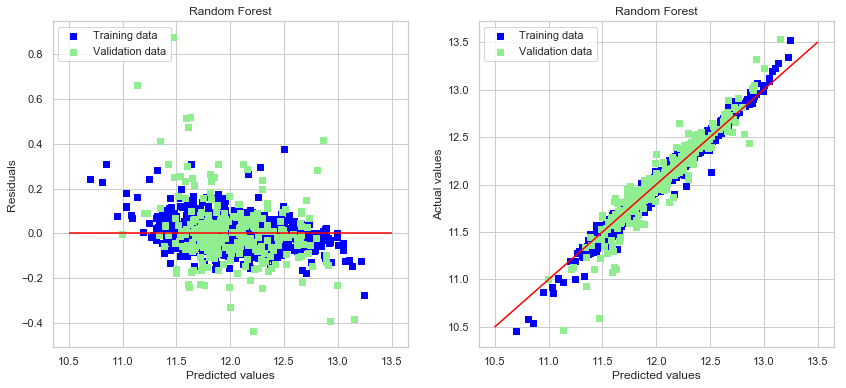

In [277]:
y_train_pred_rf = rf_best.predict(X_train)
y_test_pred_rf = rf_best.predict(X_test)
rnd_dig = 4
print('Train RMSE:', round(sqrt(sum((y_train_pred_rf-y_train)**2)/n_t_t_train),rnd_dig))
print('Validation RMSE:', round(sqrt(sum((y_test_pred_rf-y_test)**2)/n_t_t_test), rnd_dig))

plt.figure(figsize=(14, 6))

# Plot residuals
plt.subplot(1,2,1)
plt.scatter(y_train_pred_rf, y_train_pred_rf - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred_rf, y_test_pred_rf - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Random Forest")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")

# Plot predictions
plt.subplot(1,2,2)
plt.scatter(y_train_pred_rf, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred_rf, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Random Forest")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [278]:
rf_feature_imp = pd.DataFrame(list(zip(col_names,list(rf_best.feature_importances_))))
rf_feature_imp.columns = ['variable', 'importance']

In [280]:
rf_feature_imp.sort_values(by='importance', ascending=False).head(20)

,variable,importance
37,TotalSF,0.363679
2,OverallQual,0.306689
17,GrLivArea,0.047792
4,YearBuilt,0.030879
7,ExterQual,0.021616
31,GarageArea,0.016462
30,GarageCars,0.015239
5,YearRemodAdd,0.013867
24,KitchenQual,0.013719
1,LotArea,0.012833


In [62]:
# Import tools needed for visualization
# Pull out one tree from the forest
tree = rf_best.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = col_names, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [281]:
y_test_final_pred_rf = np.exp(rf_best.predict(np.array(test_no_Id_df)))
test_upload_rf = pd.DataFrame(data = {'Id': test_Id, 'SalePrice': y_test_final_pred_rf})
test_upload_rf.to_csv('solutions_kc_rf.csv', index=False)
#test_upload_rf.head(10)

,Id,SalePrice
0,1461,126562.299535
1,1462,160851.953454
2,1463,176622.747664
3,1464,185862.079087
4,1465,206977.199020
5,1466,180574.512211
6,1467,175381.233635
7,1468,176148.388198
8,1469,192245.868493
9,1470,122182.661393


##  Linear Regression - sklearn

In [282]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Train RMSE: 0.095
Validation RMSE: 0.1273


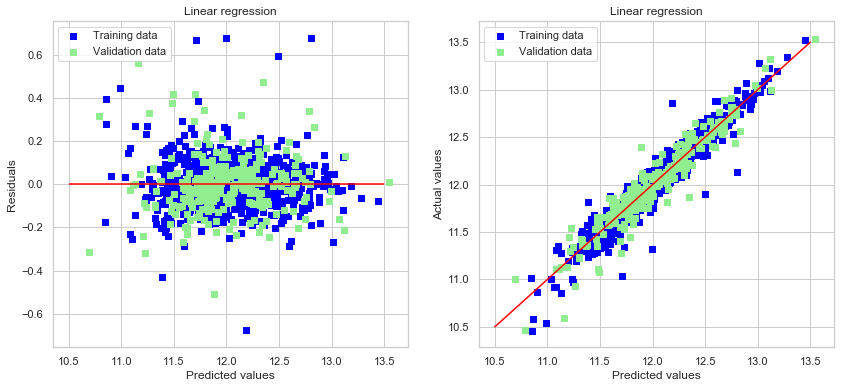

In [283]:
# Look at predictions on training and validation set
y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)

print('Train RMSE:', round(sqrt(sum((y_train_pred_lr-y_train)**2)/n_t_t_train),rnd_dig))
print('Validation RMSE:', round(sqrt(sum((y_test_pred_lr-y_test)**2)/n_t_t_test), rnd_dig))

plt.figure(figsize=(14, 6))

# Plot residuals
plt.subplot(1,2,1)
plt.scatter(y_train_pred_lr, y_train_pred_lr - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred_lr, y_test_pred_lr - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")

# Plot predictions
plt.subplot(1,2,2)
plt.scatter(y_train_pred_lr, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred_lr, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [284]:
y_test_final_pred_lr = np.exp(lr.predict(np.array(test_no_Id_df)))
test_upload_lr = pd.DataFrame(data = {'Id': test_Id, 'SalePrice': y_test_final_pred_lr})
test_upload_lr.to_csv('solutions_kc_lr.csv', index=False)
#test_upload_lr.head(10)

,Id,SalePrice
0,1461,121341.333406
1,1462,162468.457356
2,1463,175471.104462
3,1464,195306.202005
4,1465,197519.732669
5,1466,172831.076579
6,1467,179946.834392
7,1468,165020.082017
8,1469,191843.860396
9,1470,120690.405748


# Lasso

In [285]:
lasso_normalize=True
lasso = Lasso(alpha=1, normalize=lasso_normalize)

In [286]:
alphas_lasso = np.logspace(-4, 2, 100)
coef_lasso = []
for i in alphas_lasso:
    lasso.set_params(alpha = i).fit(X_train, y_train)
    coef_lasso.append(lasso.coef_)

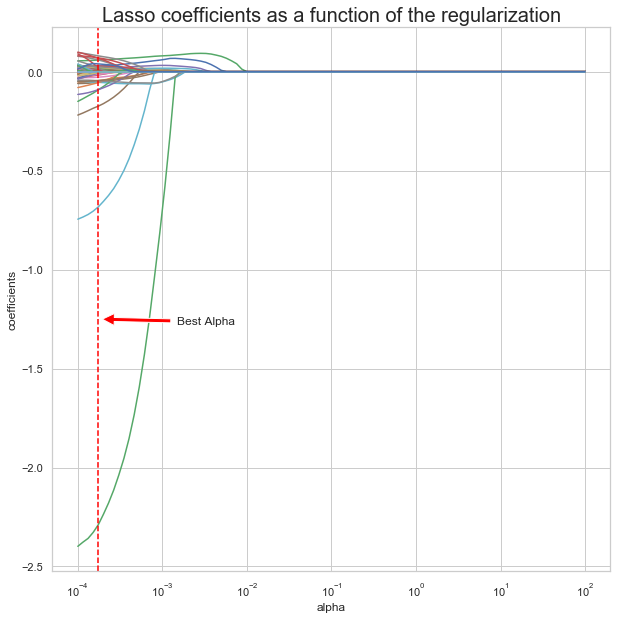

In [430]:
columns = X_train.columns
lasso_coef_df = pd.DataFrame(coef_lasso, index=alphas_lasso, columns=columns)

fig = plt.figure(figsize=(10,10))
plt.plot(lasso_coef_df)
plt.title('Lasso coefficients as a function of the regularization', fontsize=20)
plt.xscale('log')
#plt.axis([min(alphas_lasso),1,-3,0.5])
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.axvline(x=best_alpha_lasso, c='red', linestyle='--')
plt.annotate('Best Alpha', xy=(best_alpha_lasso, -1.25), xytext=(.0015,-1.275), arrowprops=dict(facecolor='red', shrink=0.05))
plt.show()

In [288]:
from sklearn.model_selection import GridSearchCV
lasso_ = Lasso(normalize=lasso_normalize)
grid_param_lasso = [{'alpha': alphas_lasso}]
para_search_lasso = GridSearchCV(estimator=lasso_, param_grid=grid_param_lasso, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
para_search_lasso = para_search_lasso.fit(X_train, y_train)

In [291]:
para_search_lasso.best_params_
best_alpha_lasso = para_search_lasso.best_params_['alpha']

In [293]:
lasso_best = Lasso(alpha=para_search_lasso.best_params_['alpha'], normalize = lasso_normalize)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.0001747528400007683, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Train RMSE: 0.1072
Validation RMSE: 0.124


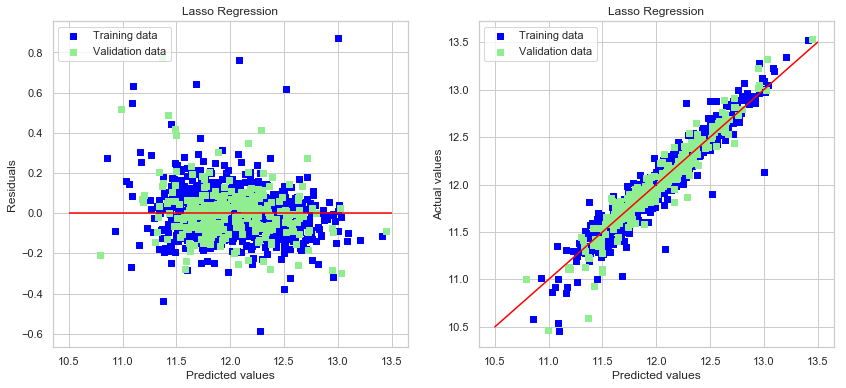

In [294]:
y_train_pred_lasso = lasso_best.predict(X_train)
y_test_pred_lasso = lasso_best.predict(X_test)

print('Train RMSE:', round(sqrt(sum((y_train_pred_lasso-y_train)**2)/n_t_t_train),rnd_dig))
print('Validation RMSE:', round(sqrt(sum((y_test_pred_lasso-y_test)**2)/n_t_t_test), rnd_dig))

plt.figure(figsize=(14, 6))

# Plot residuals
plt.subplot(1,2,1)
plt.scatter(y_train_pred_lasso, y_train_pred_lasso - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred_lasso, y_test_pred_lasso - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Lasso Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")

# Plot predictions
plt.subplot(1,2,2)
plt.scatter(y_train_pred_lasso, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred_lasso, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Lasso Regression")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [329]:
lasso_best_coef = pd.DataFrame(pd.concat([pd.Series(columns),pd.Series(lasso_best.coef_)], axis=1))
lasso_best_coef.columns=['variable', 'lasso_coeff']

In [330]:
lasso_best_coef.loc[abs(lasso_best_coef['lasso_coeff']).sort_values(ascending=False).index].head(20)

,variable,lasso_coeff
142,RoofMatl_ClyTile,-2.288954
119,Condition2_PosN,-0.682882
55,MSZoning_C (all),-0.173830
152,Exterior1st_BrkComm,-0.090997
194,Heating_Grav,-0.090656
87,Neighborhood_Crawfor,0.080260
153,Exterior1st_BrkFace,0.070000
103,Neighborhood_StoneBr,0.068109
97,Neighborhood_NridgHt,0.059469
2,OverallQual,0.059013


In [298]:
y_test_final_pred_lasso = np.exp(lasso_best.predict(np.array(test_no_Id_df)))
test_upload_lasso = pd.DataFrame(data = {'Id': test_Id, 'SalePrice': y_test_final_pred_lasso})
test_upload_lasso.to_csv('solutions_kc_lasso.csv', index=False)
#test_upload_lasso.head(10)

,Id,SalePrice
0,1461,121172.303424
1,1462,153765.337553
2,1463,175602.378592
3,1464,193669.535505
4,1465,198860.841405
5,1466,173709.914750
6,1467,182257.699258
7,1468,165258.025041
8,1469,194974.532776
9,1470,121774.914456


## Ridge

In [299]:
ridge_normalize = True
ridge = Ridge(alpha=1, normalize=ridge_normalize)

In [300]:
alphas_ridge = np.logspace(-4, 2, 100)
coef_ridge = []
for i in alphas_ridge:
    ridge.set_params(alpha = i).fit(X_train, y_train)
    coef_ridge.append(ridge.coef_)


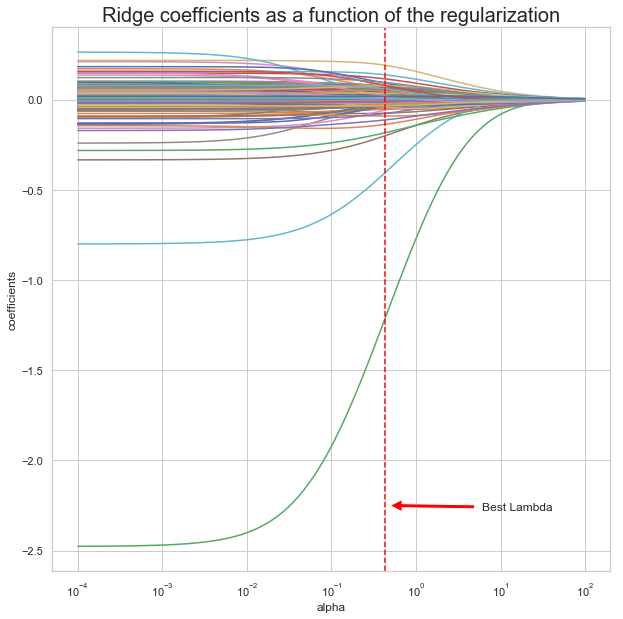

In [427]:
columns = X_train.columns
ridge_coef_df = pd.DataFrame(coef_ridge, index=alphas_ridge, columns=columns)

fig = plt.figure(figsize=(10,10))
plt.plot(ridge_coef_df)
plt.title('Ridge coefficients as a function of the regularization', fontsize=20)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.axvline(x=best_alpha_ridge, c='red', linestyle='--')
plt.annotate('Best Lambda', xy=(best_alpha_ridge, -2.25), xytext=(6,-2.275), arrowprops=dict(facecolor='red', shrink=0.05))
plt.show()

In [302]:
ridge_ = Ridge(normalize=ridge_normalize)
grid_param_ridge = [{'alpha': alphas_ridge}]
para_search_ridge = GridSearchCV(estimator=ridge_, param_grid=grid_param_ridge, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
para_search_ridge = para_search_ridge.fit(X_train, y_train)

In [304]:
para_search_ridge.best_params_
best_alpha_ridge = para_search_ridge.best_params_['alpha']

In [306]:
ridge_best = Ridge(alpha=para_search_ridge.best_params_['alpha'], normalize = ridge_normalize)
ridge_best.fit(X_train, y_train)

Ridge(alpha=0.43287612810830617, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=True, random_state=None, solver='auto',
   tol=0.001)

Train RMSE: 0.1073
Validation RMSE: 0.1313


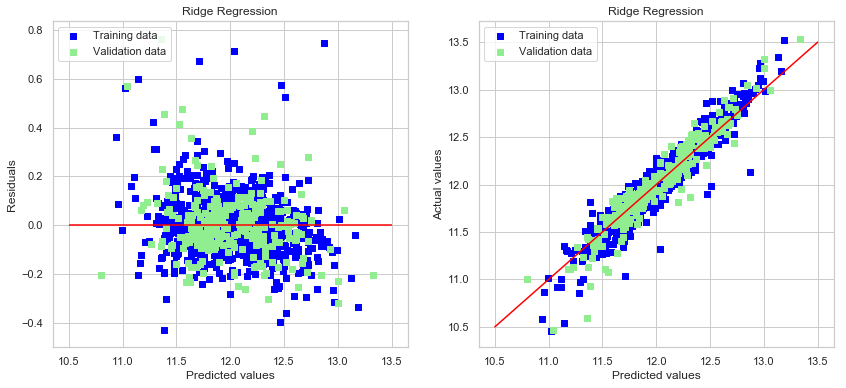

In [307]:
y_train_pred_ridge = ridge_best.predict(X_train)
y_test_pred_ridge = ridge_best.predict(X_test)

print('Train RMSE:', round(sqrt(sum((y_train_pred_ridge-y_train)**2)/n_t_t_train),rnd_dig))
print('Validation RMSE:', round(sqrt(sum((y_test_pred_ridge-y_test)**2)/n_t_t_test), rnd_dig))

plt.figure(figsize=(14, 6))

# Plot residuals
plt.subplot(1,2,1)
plt.scatter(y_train_pred_ridge, y_train_pred_ridge - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred_ridge, y_test_pred_ridge - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Ridge Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")

# Plot predictions
plt.subplot(1,2,2)
plt.scatter(y_train_pred_ridge, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred_ridge, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Ridge Regression")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [328]:
ridge_best_coef = pd.DataFrame(pd.concat([pd.Series(columns),pd.Series(ridge_best.coef_)], axis=1))
ridge_best_coef.columns=['variable', 'ridge_coeff']

In [309]:
#ridge_best_coef[abs(ridge_best_coef['ridge_coeff']) > 1e-10].sort_values(by='ridge_coeff', ascending=False).head(20)
ridge_best_coef.loc[abs(ridge_best_coef['ridge_coeff']).sort_values(ascending=False).index].head(20)

,variable,ridge_coeff
142,RoofMatl_ClyTile,-1.210365
119,Condition2_PosN,-0.404075
55,MSZoning_C (all),-0.199811
118,Condition2_PosA,0.190859
152,Exterior1st_BrkComm,-0.183108
149,RoofMatl_WdShngl,0.137792
91,Neighborhood_MeadowV,-0.136658
103,Neighborhood_StoneBr,0.115151
194,Heating_Grav,-0.111992
237,SaleCondition_Alloca,0.095602


In [311]:
y_test_final_pred_ridge = np.exp(ridge_best.predict(np.array(test_no_Id_df)))
test_upload_ridge = pd.DataFrame(data = {'Id': test_Id, 'SalePrice': y_test_final_pred_ridge})
test_upload_ridge.to_csv('solutions_kc_ridge.csv', index=False)
#test_upload_ridge.head(10)

,Id,SalePrice
0,1461,120686.556140
1,1462,156992.464784
2,1463,176569.809297
3,1464,195646.538613
4,1465,192574.004290
5,1466,174168.578365
6,1467,175689.138403
7,1468,171984.294592
8,1469,177079.665176
9,1470,125595.778636


## Lasso/Ridge Comparison

In [312]:
lasso_and_ridge_coef_df = lasso_best_coef.merge(ridge_best_coef,on='variable')
lasso_and_ridge_coef_df = lasso_and_ridge_coef_df.merge(column_counts, how='left', on='variable')

In [313]:
# top positive factors identified by lasso
lasso_and_ridge_coef_df.sort_values('lasso_coeff', ascending=False).head(15)

,variable,lasso_coeff,ridge_coeff,count
87,Neighborhood_Crawfor,0.080260,0.076431,44
153,Exterior1st_BrkFace,0.070000,0.068641,40
103,Neighborhood_StoneBr,0.068109,0.115151,20
97,Neighborhood_NridgHt,0.059469,0.074716,61
2,OverallQual,0.059013,0.029358,1168
240,SaleCondition_Partial,0.039520,0.018422,98
123,BldgType_1Fam,0.028612,0.016519,978
30,GarageCars,0.028190,0.028289,1168
3,OverallCond,0.027546,0.018661,1168
26,Functional,0.027048,0.022116,1168


In [314]:
# top negative factors identified by lasso
lasso_and_ridge_coef_df.sort_values('lasso_coeff', ascending=True).head(15)

,variable,lasso_coeff,ridge_coeff,count
142,RoofMatl_ClyTile,-2.288954,-1.210365,1
119,Condition2_PosN,-0.682882,-0.404075,2
55,MSZoning_C (all),-0.173830,-0.199811,4
152,Exterior1st_BrkComm,-0.090997,-0.183108,2
194,Heating_Grav,-0.090656,-0.111992,6
91,Neighborhood_MeadowV,-0.054903,-0.136658,10
59,MSZoning_RM,-0.053592,-0.026327,172
45,MSSubClass_SC30,-0.051930,-0.074718,50
197,CentralAir_N,-0.045736,-0.036305,83
41,MSSubClass_SC160,-0.045073,-0.052279,49


In [315]:
# top positive factors identified by ridge
lasso_and_ridge_coef_df.sort_values('ridge_coeff', ascending=False).head(15)

,variable,lasso_coeff,ridge_coeff,count
118,Condition2_PosA,0.000000,0.190859,1
149,RoofMatl_WdShngl,0.000000,0.137792,4
103,Neighborhood_StoneBr,0.068109,0.115151,20
237,SaleCondition_Alloca,0.019299,0.095602,7
160,Exterior1st_Stone,0.000000,0.091758,1
233,SaleType_Oth,0.019521,0.079729,2
87,Neighborhood_Crawfor,0.080260,0.076431,44
228,SaleType_Con,0.000000,0.076410,2
97,Neighborhood_NridgHt,0.059469,0.074716,61
227,SaleType_CWD,0.000000,0.073478,4


In [316]:
# top negative factors identified by ridge
lasso_and_ridge_coef_df.sort_values('ridge_coeff', ascending=True).head(15)

,variable,lasso_coeff,ridge_coeff,count
142,RoofMatl_ClyTile,-2.288954,-1.210365,1
119,Condition2_PosN,-0.682882,-0.404075,2
55,MSZoning_C (all),-0.173830,-0.199811,4
152,Exterior1st_BrkComm,-0.090997,-0.183108,2
91,Neighborhood_MeadowV,-0.054903,-0.136658,10
194,Heating_Grav,-0.090656,-0.111992,6
191,Heating_Floor,-0.000000,-0.090700,1
204,GarageType_2Types,-0.005388,-0.076420,6
45,MSSubClass_SC30,-0.051930,-0.074718,50
76,LotConfig_FR3,-0.000000,-0.057800,3


In [317]:
num_obs_train = len(y_train)
print('Lasso Train MSE: ', sum((lasso_best.predict(X_train)-y_train)**2)/num_obs_train)
print('Ridge Train MSE: ', sum((ridge_best.predict(X_train)-y_train)**2)/num_obs_train)

Lasso Train MSE:  0.011499827312790431
Ridge Train MSE:  0.011518590697168233


In [338]:
lasso_and_ridge_coef_df_no_count = lasso_and_ridge_coef_df.drop('count', axis=1)

In [339]:
lasso_and_ridge_coef_df_no_count.head()

,variable,lasso_coeff,ridge_coeff
0,LotFrontage,0.000000,0.000079
1,LotArea,0.000001,0.000001
2,OverallQual,0.059013,0.029358
3,OverallCond,0.027546,0.018661
4,YearBuilt,0.001337,0.000485


## Variable Importance

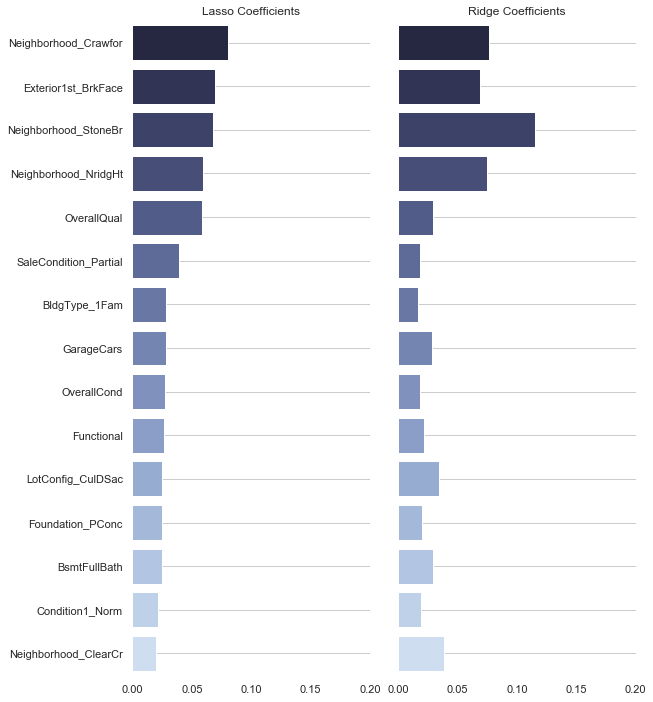

In [453]:
sns.set(style="whitegrid")

# define data
data_plot = lasso_and_ridge_coef_df.sort_values('lasso_coeff', ascending=False).head(15)

plot_order = ['lasso_coeff', 'ridge_coeff']


# Make the PairGrid
g = sns.PairGrid(data_plot,
                 x_vars=plot_order, y_vars=["variable"],
                 height=10, aspect=.4)

# Draw a dot plot using the stripplot function
palette_to_use = "ch:s=3,r=-.1,h=1_r"

g.map(sns.barplot, orient="h", palette=palette_to_use, linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 0.2), xlabel='', ylabel='')

# Use semantically meaningful titles for the columns
titles = ["Lasso Coefficients", "Ridge Coefficients"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

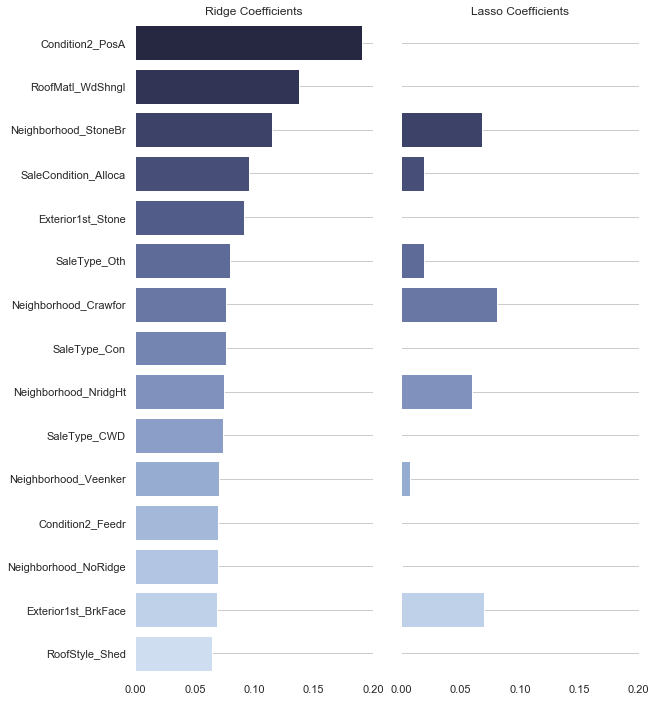

In [454]:
sns.set(style="whitegrid")

# define data
data_plot = lasso_and_ridge_coef_df.sort_values('ridge_coeff', ascending=False).head(15)

plot_order = ['ridge_coeff', 'lasso_coeff']

# Make the PairGrid
g = sns.PairGrid(data_plot,
                 x_vars=plot_order, y_vars=["variable"],
                 height=10, aspect=.4)

# Draw a dot plot using the stripplot function
palette_to_use = "ch:s=3,r=-.1,h=1_r"

g.map(sns.barplot, orient="h", palette=palette_to_use, linewidth=1, edgecolor="w")

#sns.dark_palette('navy', reverse=True)

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 0.2), xlabel='', ylabel='')

# Use semantically meaningful titles for the columns
titles = ["Ridge Coefficients", "Lasso Coefficients"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

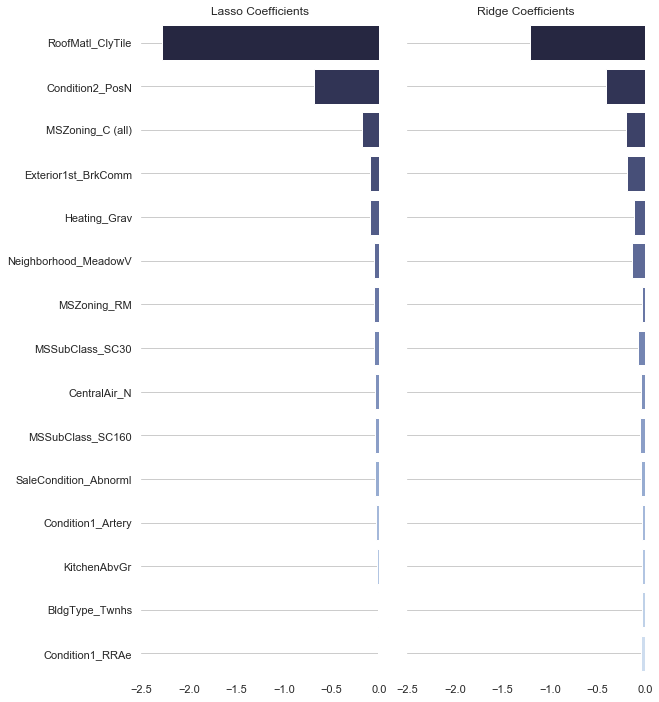

In [457]:
sns.set(style="whitegrid")

# define data
data_plot = lasso_and_ridge_coef_df.sort_values('lasso_coeff', ascending=True).head(15)

plot_order = ['lasso_coeff', 'ridge_coeff']


# Make the PairGrid
g = sns.PairGrid(data_plot,
                 x_vars=plot_order, y_vars=["variable"],
                 height=10, aspect=.4)

# Draw a dot plot using the stripplot function
palette_to_use = "ch:s=3,r=-.1,h=1_r"

g.map(sns.barplot, orient="h", palette=palette_to_use, linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-2.5, 0), xlabel='', ylabel='')

# Use semantically meaningful titles for the columns
titles = ["Lasso Coefficients", "Ridge Coefficients"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

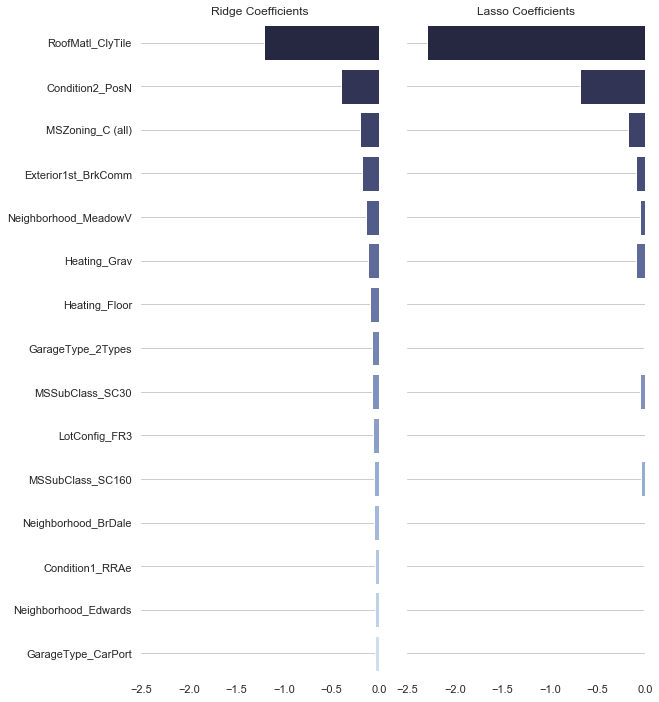

In [456]:
sns.set(style="whitegrid")

# define data
data_plot = lasso_and_ridge_coef_df.sort_values('ridge_coeff', ascending=True).head(15)

plot_order = ['ridge_coeff', 'lasso_coeff']

# Make the PairGrid
g = sns.PairGrid(data_plot,
                 x_vars=plot_order, y_vars=["variable"],
                 height=10, aspect=.4)

# Draw a dot plot using the stripplot function
palette_to_use = "ch:s=3,r=-.1,h=1_r"

g.map(sns.barplot, orient="h", palette=palette_to_use, linewidth=1, edgecolor="w")

#sns.dark_palette('navy', reverse=True)

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-2.5, 0), xlabel='', ylabel='')

# Use semantically meaningful titles for the columns
titles = ["Ridge Coefficients", "Lasso Coefficients"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [481]:
lasso_best_coef2 = lasso_and_ridge_coef_df.loc[lasso_and_ridge_coef_df['count'] > 10, ['variable', 'lasso_coeff']].copy()
lasso_best_coef2['lasso_coeff_abs'] = abs(lasso_best_coef2['lasso_coeff'])

In [483]:
lasso_best_coef2.sort_values('lasso_coeff_abs', ascending=False).head(15)

,variable,lasso_coeff,lasso_coeff_abs
87,Neighborhood_Crawfor,0.080260,0.080260
153,Exterior1st_BrkFace,0.070000,0.070000
103,Neighborhood_StoneBr,0.068109,0.068109
97,Neighborhood_NridgHt,0.059469,0.059469
2,OverallQual,0.059013,0.059013
59,MSZoning_RM,-0.053592,0.053592
45,MSSubClass_SC30,-0.051930,0.051930
197,CentralAir_N,-0.045736,0.045736
41,MSSubClass_SC160,-0.045073,0.045073
235,SaleCondition_Abnorml,-0.044211,0.044211


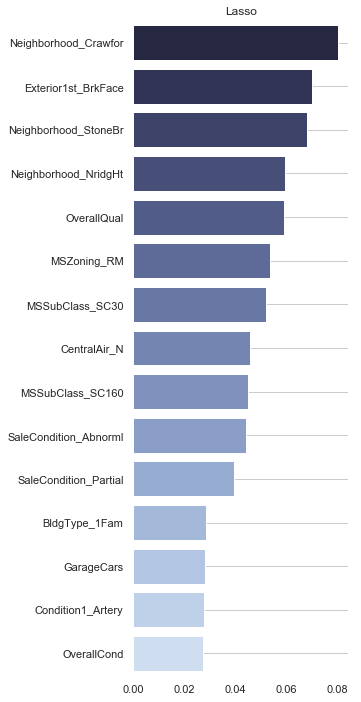

In [484]:
sns.set(style="whitegrid")

# define data
data_plot = lasso_best_coef2.sort_values('lasso_coeff_abs', ascending=False).head(15)

plot_order = ['lasso_coeff_abs']

# Make the PairGrid
g = sns.PairGrid(data_plot,
                 x_vars=plot_order, y_vars=["variable"],
                 height=10, aspect=.4)

# Draw a dot plot using the stripplot function
palette_to_use = "ch:s=3,r=-.1,h=1_r"

g.map(sns.barplot, orient="h", palette=palette_to_use, linewidth=1, edgecolor="w")

#sns.dark_palette('navy', reverse=True)

# Use the same x axis limits on all columns and add better labels
g.set(xlabel='', ylabel='')

# Use semantically meaningful titles for the columns
titles = ["Lasso"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [485]:
ridge_best_coef2 = lasso_and_ridge_coef_df.loc[lasso_and_ridge_coef_df['count'] > 10, ['variable', 'ridge_coeff']].copy()
ridge_best_coef2['ridge_coeff_abs'] = abs(ridge_best_coef2['ridge_coeff'])
ridge_best_coef2.sort_values('ridge_coeff_abs', ascending=False).head(15)

,variable,ridge_coeff,ridge_coeff_abs
103,Neighborhood_StoneBr,0.115151,0.115151
87,Neighborhood_Crawfor,0.076431,0.076431
45,MSSubClass_SC30,-0.074718,0.074718
97,Neighborhood_NridgHt,0.074716,0.074716
96,Neighborhood_NoRidge,0.069306,0.069306
153,Exterior1st_BrkFace,0.068641,0.068641
41,MSSubClass_SC160,-0.052279,0.052279
193,Heating_GasW,0.051874,0.051874
83,Neighborhood_BrDale,-0.048884,0.048884
136,RoofStyle_Flat,0.045594,0.045594


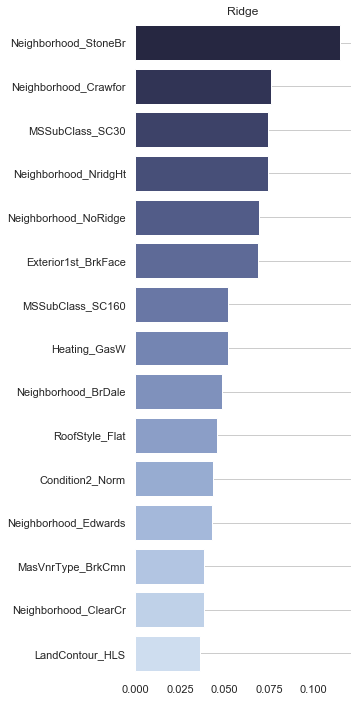

In [487]:
sns.set(style="whitegrid")

# define data
data_plot = ridge_best_coef2.sort_values('ridge_coeff_abs', ascending=False).head(15)

plot_order = ['ridge_coeff_abs']

# Make the PairGrid
g = sns.PairGrid(data_plot,
                 x_vars=plot_order, y_vars=["variable"],
                 height=10, aspect=.4)

# Draw a dot plot using the stripplot function
palette_to_use = "ch:s=3,r=-.1,h=1_r"

g.map(sns.barplot, orient="h", palette=palette_to_use, linewidth=1, edgecolor="w")

#sns.dark_palette('navy', reverse=True)

# Use the same x axis limits on all columns and add better labels
g.set(xlabel='', ylabel='')

# Use semantically meaningful titles for the columns
titles = ["Ridge"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [489]:
rf_feature_imp.sort_values(by='importance', ascending=False).head(15)

,variable,importance
37,TotalSF,0.363679
2,OverallQual,0.306689
17,GrLivArea,0.047792
4,YearBuilt,0.030879
7,ExterQual,0.021616
31,GarageArea,0.016462
30,GarageCars,0.015239
5,YearRemodAdd,0.013867
24,KitchenQual,0.013719
1,LotArea,0.012833


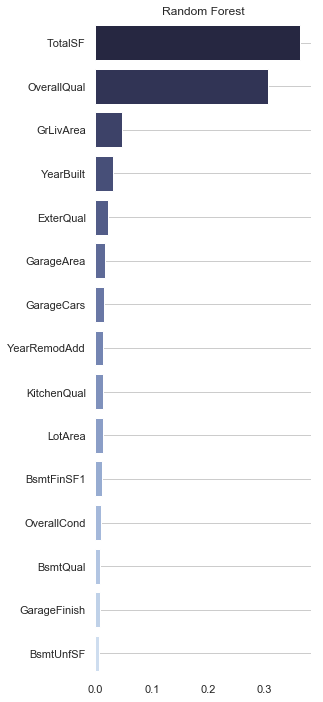

In [490]:
sns.set(style="whitegrid")

# define data
data_plot = rf_feature_imp.sort_values(by='importance', ascending=False).head(15)

plot_order = ['importance']

# Make the PairGrid
g = sns.PairGrid(data_plot,
                 x_vars=plot_order, y_vars=["variable"],
                 height=10, aspect=.4)

# Draw a dot plot using the stripplot function
palette_to_use = "ch:s=3,r=-.1,h=1_r"

g.map(sns.barplot, orient="h", palette=palette_to_use, linewidth=1, edgecolor="w")

#sns.dark_palette('navy', reverse=True)

# Use the same x axis limits on all columns and add better labels
g.set(xlabel='', ylabel='')

# Use semantically meaningful titles for the columns
titles = ["Random Forest"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [497]:
lgb_importance = pd.read_csv('lgb_variable_importances.csv')

In [499]:
lgb_importance.head(15)

,variable,importance
0,YearBuilt,125
1,LotArea,121
2,TotalSF,119
3,GrLivArea,108
4,1stFlrSF,101
5,OverallCond,99
6,BsmtUnfSF,86
7,GarageArea,80
8,OutdoorSF,80
9,BsmtFinSF1,77


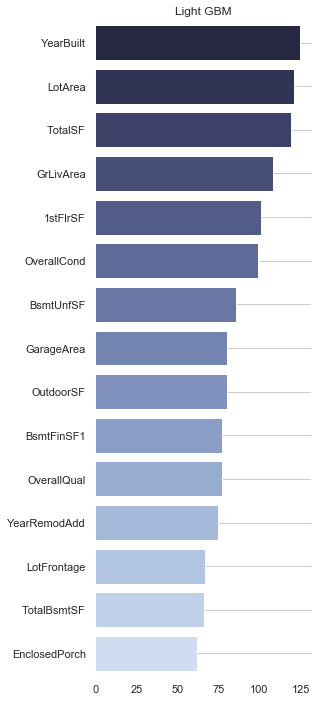

In [500]:
sns.set(style="whitegrid")

# define data
data_plot = lgb_importance.sort_values(by='importance', ascending=False).head(15)

plot_order = ['importance']

# Make the PairGrid
g = sns.PairGrid(data_plot,
                 x_vars=plot_order, y_vars=["variable"],
                 height=10, aspect=.4)

# Draw a dot plot using the stripplot function
palette_to_use = "ch:s=3,r=-.1,h=1_r"

g.map(sns.barplot, orient="h", palette=palette_to_use, linewidth=1, edgecolor="w")

#sns.dark_palette('navy', reverse=True)

# Use the same x axis limits on all columns and add better labels
g.set(xlabel='', ylabel='')

# Use semantically meaningful titles for the columns
titles = ["Light GBM"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [501]:
xgb_importance = pd.read_csv('xgb_variable_importances.csv')

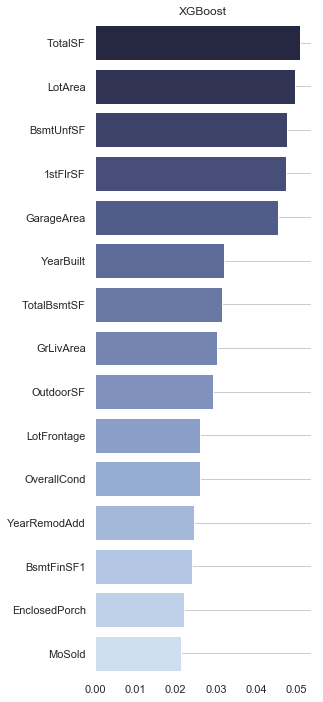

In [502]:
sns.set(style="whitegrid")

# define data
data_plot = xgb_importance.sort_values(by='importance', ascending=False).head(15)

plot_order = ['importance']

# Make the PairGrid
g = sns.PairGrid(data_plot,
                 x_vars=plot_order, y_vars=["variable"],
                 height=10, aspect=.4)

# Draw a dot plot using the stripplot function
palette_to_use = "ch:s=3,r=-.1,h=1_r"

g.map(sns.barplot, orient="h", palette=palette_to_use, linewidth=1, edgecolor="w")

#sns.dark_palette('navy', reverse=True)

# Use the same x axis limits on all columns and add better labels
g.set(xlabel='', ylabel='')

# Use semantically meaningful titles for the columns
titles = ["XGBoost"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)